In [1]:
import pandas as pd
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
sys.path.append('../External_Functions')
from ExternalFunctions import nice_string_output, add_text_to_ax   # Useful functions to print fit results on figure
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
import statistics 
from scipy import stats

In [2]:
from IPython.core.display import Latex

def lprint(*args,**kwargs):
    """Pretty print arguments as LaTeX using IPython display system 
    
    Parameters
    ----------
    args : tuple 
        What to print (in LaTeX math mode)
    kwargs : dict 
        optional keywords to pass to `display` 
    """
    display(Latex('$$'+' '.join(args)+'$$'),**kwargs)

Problem 5.1

In [3]:
df = pd.read_table('data_LukeLightningLights.txt', header = None, sep = '\s+')
x_full, ex_full, y_full, ey_full = df.values.T

In [4]:
Minuit.print_level = 0

y = y_full[:12]
ey = ey_full[:12]
x = x_full[:12]

def fit_func(x, a):
    return np.zeros_like(x) + a

def chi2_calc(a):
    y_fit = fit_func(x, a)
    chi2 = np.sum(((y - y_fit) / ey)**2)
    return chi2
chi2_calc.errordef = 1.0

# Here we let Minuit know, what to minimise, how, and with what starting parameters:   
minuit = Minuit(chi2_calc, a = 1) # initial guess

# Perform the actual fit:
minuit.migrad()

Nvar = 1                    # Number of variables
Ndof_fit = len(y) - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2 = minuit.fval                          # The chi2 value
Prob = stats.chi2.sf(Chi2, Ndof_fit)    # The chi2 probability given N degrees of freedom

print(Chi2, Prob)

21.968009641873277 0.02462225183789594


In [5]:
# Not consistent with being constant at a 95% confidence level

In [6]:
Minuit.print_level = 0

def fit_func(x, a, b):
    return a * x + b

def chi2_calc(a, b):
    y_fit = fit_func(x, a, b)
    chi2 = np.sum(((y - y_fit) / ey)**2)
    return chi2
chi2_calc.errordef = 1.0

Chi2_list = []
Prob_list = []

for i in range(len(y_full[11:])):

    y = y_full[:i+11]
    ey = ey_full[:i+11]
    x = x_full[:i+11]

    # Here we let Minuit know, what to minimise, how, and with what starting parameters:   
    minuit = Minuit(chi2_calc, a = 1, b = 1) # initial guess

    # Perform the actual fit:
    minuit.migrad()

    Nvar = 2                    # Number of variables
    Ndof_fit = len(y) - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

    # Get the minimal value obtained for the quantity to be minimised (here the Chi2)
    Chi2 = minuit.fval                          # The chi2 value
    Prob = stats.chi2.sf(Chi2, Ndof_fit)    # The chi2 probability given N degrees of freedom

    Chi2_list.append(Chi2)
    Prob_list.append(Prob)

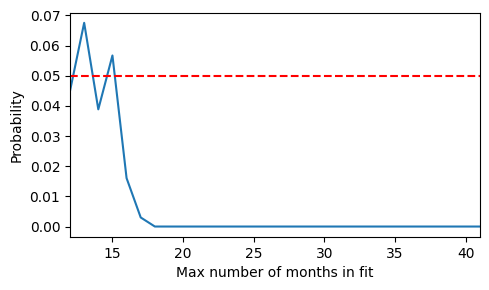

In [7]:
fig, ax = plt.subplots(figsize = (5, 3))

ax.plot(x_full[11:], Prob_list)
ax.hlines(0.05, min(x_full[11:]), max(x_full[11:]), ls = '--', color = 'r')

ax.set(xlabel = 'Max number of months in fit', ylabel = 'Probability', xlim = (min(x_full[11:]), max(x_full[11:])))

fig.tight_layout()

In [8]:
# Import SymPy: 
from sympy import * 
    
# Define variables:
Y_d, y1, y2 = symbols("Y_d, y_1, y_2")
dY_d, dy1, dy2 = symbols("sigma_Y_d, sigma_y_1, sigma_y_2")

# Define relation, and print:
Y_d = y1 - y2
lprint(latex(Eq(symbols('Y_d'), Y_d)))

# Calculate uncertainty and print:
dY_d = sqrt((Y_d.diff(y1) * dy1)**2 + (Y_d.diff(y2) * dy2)**2)
lprint(latex(Eq(symbols('sigma_Y_d'), dY_d)))

# Turn expression into numerical functions 
# lambdify transform SymPy expressions to lambda functions which can be used to calculate numerical values very fast
fY_d = lambdify((y1, y2), Y_d)
fdY_d = lambdify((y1, dy1, y2, dy2), dY_d)

# Define values and their errors
vy1, vdy1 = y_full[30], ey_full[30]
vy2, vdy2 = y_full[31], ey_full[31]

# Numerically evaluate expressions and print 
vY_d = fY_d(vy1, vy2)
vdY_d = fdY_d(vy1, vdy1, vy2, vdy2)
lprint(fr'Y_d = {vY_d:.1f} \pm {vdY_d:.1f}')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [9]:
Minuit.print_level = 0

def logistic(x, A, K, C, Q, B, nu):
    return A + ((K - A) / (C + Q * np.exp(- B * x))**(1/nu))

def chi2_calc(A, K, C, Q, B, nu):
    y_fit = logistic(x, A, K, C, Q, B, nu)
    chi2 = np.sum(((y - y_fit) / ey)**2)
    return chi2
chi2_calc.errordef = 1.0

y = y_full
ey = ey_full
x = x_full

# Here we let Minuit know, what to minimise, how, and with what starting parameters:   
minuit = Minuit(chi2_calc, A = 0, K = 1, C = 1, Q = 1, B = 1, nu = 1) # initial guess

# Perform the actual fit:
minuit.migrad()

Nvar = 6                    # Number of variables
Ndof_fit = len(y) - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2 = minuit.fval                          # The chi2 value
Prob = stats.chi2.sf(Chi2, Ndof_fit)    # The chi2 probability given N degrees of freedom

print(Chi2, Prob)

168.47927115959544 2.2219305859227555e-19


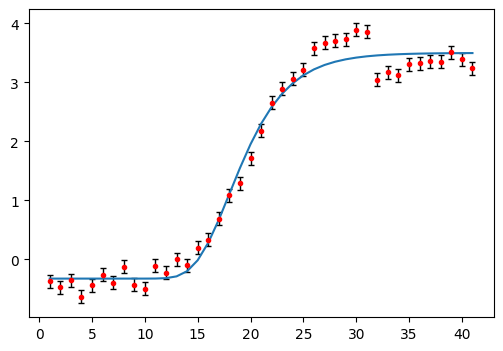

In [10]:
fig, ax = plt.subplots(figsize = (6, 4))

ax.errorbar(x_full, y_full, ey_full, fmt = ".", color='r', ecolor='k', elinewidth=1, capsize=2, capthick=1)
ax.plot(x_full, logistic(x_full, *minuit.values))

In [11]:
Minuit.print_level = 0

def logistic(x, A, K, C, Q, B, nu):
    return A + ((K - A) / (C + Q * np.exp(- B * x))**(1/nu))

y_log = y_full[:31]
ey_log = ey_full[:31]
x_log = x_full[:31]

def chi2_calc_log(A, K, C, Q, B, nu):
    y_fit = logistic(x_log, A, K, C, Q, B, nu)
    chi2 = np.sum(((y_log - y_fit) / ey_log)**2)
    return chi2
chi2_calc_log.errordef = 1.0

# Here we let Minuit know, what to minimise, how, and with what starting parameters:   
minuit_log = Minuit(chi2_calc_log, A = 0, K = 1, C = 1, Q = 1, B = 1, nu = 1) # initial guess

# Perform the actual fit:
minuit_log.migrad()

Nvar_log = 6                    # Number of variables
Ndof_fit_log = len(y_log) - Nvar_log    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_log = minuit_log.fval                          # The chi2 value
Prob_log = stats.chi2.sf(Chi2_log, Ndof_fit_log)    # The chi2 probability given N degrees of freedom

print(Chi2_log, Prob_log)

27.51762356268607 0.3305318600472243


In [12]:
Minuit.print_level = 0

def fit_func(x, a, b):
    return a * x + b

def chi2_calc(a, b):
    y_fit = fit_func(x, a, b)
    chi2 = np.sum(((y - y_fit) / ey)**2)
    return chi2
chi2_calc.errordef = 1.0

y = y_full[31:]
ey = ey_full[31:]
x = x_full[31:]

# Here we let Minuit know, what to minimise, how, and with what starting parameters:   
minuit = Minuit(chi2_calc, a = 1, b = 1) # initial guess

# Perform the actual fit:
minuit.migrad()

Nvar = 2                    # Number of variables
Ndof_fit = len(y) - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2 = minuit.fval                          # The chi2 value
Prob = stats.chi2.sf(Chi2, Ndof_fit)    # The chi2 probability given N degrees of freedom

print(Chi2, Prob)

7.072933633859249 0.5287845433699097


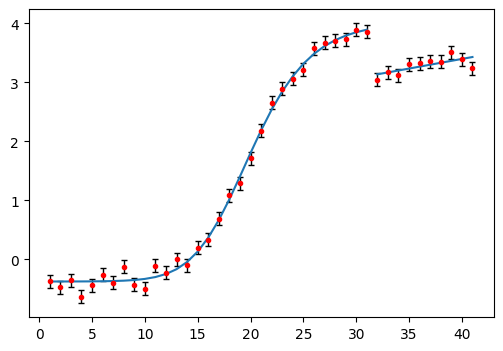

In [13]:
fig, ax = plt.subplots(figsize = (6, 4))

ax.errorbar(x_full, y_full, ey_full, fmt = ".", color='r', ecolor='k', elinewidth=1, capsize=2, capthick=1)
ax.plot(x_full[:31], logistic(x_full[:31], *minuit_log.values), color = 'tab:blue')
ax.plot(x_full[31:], fit_func(x_full[31:], *minuit.values), color = 'tab:blue')

Problem 5.2

In [14]:
df = pd.read_table('data_TimingResiduals.txt', header = None)
time_res = df[0].values.T

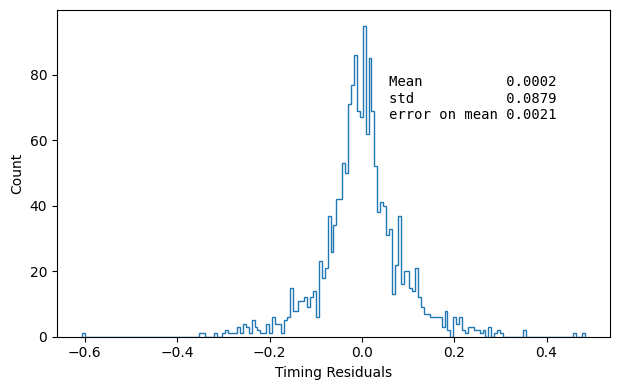

In [15]:
Nbins = int(len(time_res) / 10)
# binwidth = (xmax - xmin) / Nbins
fig, ax = plt.subplots(figsize=(6.3, 4))
ax.hist(time_res, bins=Nbins, histtype='step', label='Histogram' )
ax.set(xlabel="Timing Residuals", ylabel="Count")

# Define figure text
d = {'Mean': time_res.mean(),
     'std': time_res.std(ddof=1),
     'error on mean': time_res.std(ddof = 1) / np.sqrt(len(time_res))
    }

# Plot figure text
text = nice_string_output(d, extra_spacing=1, decimals=4)
add_text_to_ax(0.6, 0.8, text, ax, fontsize=10)

fig.tight_layout()
fig.savefig('time_res.png', dpi = 150)

In [16]:
# The mean is 0.1 sigma from zero, which means it is consistent with zero
# There are a lot of points, which are more than 3 sigma away from the mean, these seem suspicious

In [17]:
count, bin_edges = np.histogram(time_res, bins=Nbins)
time_res_binned = 0.5*(bin_edges[1:] + bin_edges[:-1])
s_count = np.sqrt(count)      # This is the standard for histograms - bin entries are Poisson distributed!

In [18]:
Minuit.print_level = 0

y = count
ey = s_count
x = time_res_binned

non_zero_mask = y != 0

y = y[non_zero_mask]
ey = ey[non_zero_mask]
x = x[non_zero_mask]

In [19]:
def fit_gauss(x, N, mu, sigma):
    return N * stats.norm.pdf(x, loc = mu, scale = sigma)

def chi2_gauss(N, mu, sigma) :
    y_fit = fit_gauss(x, N, mu, sigma)
    chi2 = np.sum(((y - y_fit) / ey)**2)
    return chi2
chi2_gauss.errordef = 1.0

# Here we let Minuit know, what to minimise, how, and with what starting parameters:   
minuit_gauss = Minuit(chi2_gauss, N = 1, mu = time_res_binned.mean(), sigma = time_res_binned.std(ddof=1)) # initial guess

# Perform the actual fit:
minuit_gauss.migrad()

Nvar = 3                    # Number of variables
Ndof_fit = len(y) - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_gauss = minuit_gauss.fval                          # The chi2 value
Prob_gauss = stats.chi2.sf(Chi2_gauss, Ndof_fit)    # The chi2 probability given N degrees of freedom

print(Chi2_gauss, Prob_gauss)
print(minuit_gauss.valid)

264.66485971252246 1.7623527889669332e-17
True


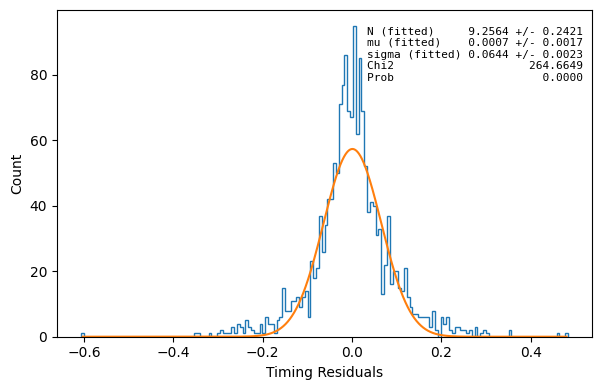

In [20]:
Nbins = int(len(time_res) / 10)
xmin, xmax = min(time_res_binned), max(time_res_binned)
binwidth = (xmax - xmin) / Nbins
x_val = np.linspace(xmin, xmax, 10000)

fig, ax = plt.subplots(figsize=(6.3, 4))
ax.hist(time_res, bins=Nbins, histtype='step', label='Histogram' )
ax.plot(x_val, fit_gauss(x_val, *minuit_gauss.values))
ax.set(xlabel="Timing Residuals", ylabel="Count")

# Define figure text
d = {'N (fitted)': [minuit_gauss.values[0], minuit_gauss.errors[0]],
     'mu (fitted)': [minuit_gauss.values[1], minuit_gauss.errors[1]],
     'sigma (fitted)': [minuit_gauss.values[2], minuit_gauss.errors[2]],
     'Chi2': Chi2_gauss,
     'Prob': Prob_gauss
    }

# Plot figure text
text = nice_string_output(d, extra_spacing=1, decimals=4)
add_text_to_ax(0.58, 0.95, text, ax, fontsize=8)

fig.tight_layout()
fig.savefig('time_res_fit1.png', dpi = 150)

In [21]:
# The fit does not converge, because the data does NOT fit a Gaussian distribution

In [22]:
# To get a better fit, all point which are more than 3 sigma away are removed
sigma = time_res.std(ddof = 1)
mask = (time_res < 3 * sigma) * (time_res > -3 * sigma)
time_res_3sig = time_res[mask]
print(time_res_3sig)

[ 0.046  0.017 -0.021 ...  0.058  0.056 -0.084]


In [23]:
count_3sig, bin_edges = np.histogram(time_res_3sig, bins=int(len(time_res_3sig)/10))
time_binned_3sig = 0.5*(bin_edges[1:] + bin_edges[:-1])
s_count_3sig = np.sqrt(count_3sig)      # This is the standard for histograms - bin entries are Poisson distributed!

In [24]:
Minuit.print_level = 0

y = count_3sig
ey = s_count_3sig
x = time_binned_3sig

non_zero_mask = y != 0

y = y[non_zero_mask]
ey = ey[non_zero_mask]
x = x[non_zero_mask]

In [25]:
def fit_gauss(x, N, mu, sigma):
    return N * stats.norm.pdf(x, loc = mu, scale = sigma)

def chi2_gauss(N, mu, sigma) :
    y_fit = fit_gauss(x, N, mu, sigma)
    chi2 = np.sum(((y - y_fit) / ey)**2)
    return chi2
chi2_gauss.errordef = 1.0

# Here we let Minuit know, what to minimise, how, and with what starting parameters:   
minuit_gauss = Minuit(chi2_gauss, N = 1, mu = time_binned_3sig.mean(), sigma = time_binned_3sig.std(ddof=1)) # initial guess

# Perform the actual fit:
minuit_gauss.migrad()

Nvar = 3                    # Number of variables
Ndof_fit = len(y) - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_gauss = minuit_gauss.fval                          # The chi2 value
Prob_gauss = stats.chi2.sf(Chi2_gauss, Ndof_fit)    # The chi2 probability given N degrees of freedom

print(Chi2_gauss, Prob_gauss)
print(minuit_gauss.valid)

317.95418175237336 1.8236307878259892e-13
True


<ValueView N=4.229021995657812 mu=0.00044045221669872063 sigma=0.05851324764410046>


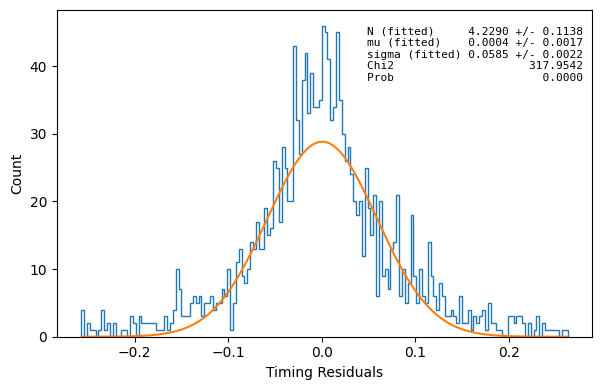

In [26]:
Nbins = int(len(time_res_3sig) / 10)
xmin, xmax = min(time_binned_3sig), max(time_binned_3sig)
binwidth = (xmax - xmin) / Nbins
x_val = np.linspace(xmin, xmax, 10000)

fig, ax = plt.subplots(figsize=(6.3, 4))
ax.hist(time_res_3sig, bins=Nbins, histtype='step', label='Histogram' )
ax.plot(x_val, fit_gauss(x_val, *minuit_gauss.values))
ax.set(xlabel="Timing Residuals", ylabel="Count")

# Define figure text
d = {'N (fitted)': [minuit_gauss.values[0], minuit_gauss.errors[0]],
     'mu (fitted)': [minuit_gauss.values[1], minuit_gauss.errors[1]],
     'sigma (fitted)': [minuit_gauss.values[2], minuit_gauss.errors[2]],
     'Chi2': Chi2_gauss,
     'Prob': Prob_gauss
    }

# Plot figure text
text = nice_string_output(d, extra_spacing=1, decimals=4)
add_text_to_ax(0.58, 0.95, text, ax, fontsize=8)

fig.tight_layout()
fig.savefig('time_res_fit2.png', dpi = 150)
print(minuit_gauss.values)

In [27]:
# Alternative PDF: Cauchy, it has a sharp peak like Gaussian, but with much longer tails

In [28]:
Minuit.print_level = 0

y = count
ey = s_count
x = time_res_binned

non_zero_mask = y != 0

y = y[non_zero_mask]
ey = ey[non_zero_mask]
x = x[non_zero_mask]

In [42]:
def fit_cauchy(x, N, x0, gamma):
    return N * stats.cauchy.pdf(x, loc = x0, scale = gamma)

def chi2_cauchy(N, x0, gamma) :
    y_fit = fit_cauchy(x, N, x0, gamma)
    chi2 = np.sum(((y - y_fit) / ey)**2)
    return chi2
chi2_cauchy.errordef = 1.0

# Here we let Minuit know, what to minimise, how, and with what starting parameters:   
minuit_cauchy = Minuit(chi2_cauchy, N = 5, x0 = x.mean(), gamma = x.std(ddof=1)) # initial guess

# Perform the actual fit:
minuit_cauchy.migrad()

Nvar = 3                    # Number of variables
Ndof_fit = len(y) - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_cauchy = minuit_cauchy.fval                          # The chi2 value
Prob_cauchy = stats.chi2.sf(Chi2_cauchy, Ndof_fit)    # The chi2 probability given N degrees of freedom

print(Chi2_cauchy, Prob_cauchy)

141.58914344896894 0.002136206402196993


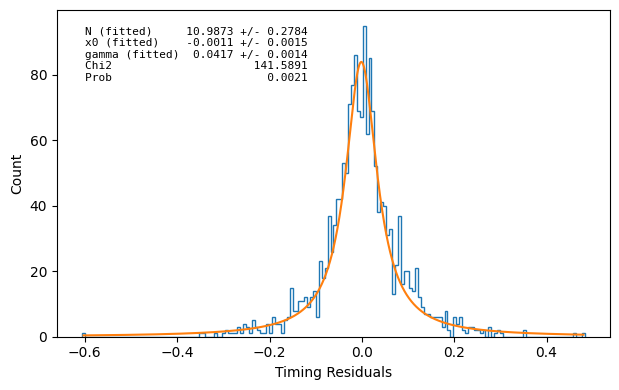

In [50]:
Nbins = int(len(time_res) / 10)
xmin, xmax = min(time_res_binned), max(time_res_binned)
binwidth = (xmax - xmin) / Nbins
x_val = np.linspace(xmin, xmax, 10000)

fig, ax = plt.subplots(figsize=(6.3, 4))
ax.hist(time_res, bins=Nbins, histtype='step', label='Histogram' )
ax.plot(x_val, fit_cauchy(x_val, *minuit_cauchy.values))
ax.set(xlabel="Timing Residuals", ylabel="Count")

# Define figure text
d = {'N (fitted)': [minuit_cauchy.values[0], minuit_cauchy.errors[0]],
     'x0 (fitted)': [minuit_cauchy.values[1], minuit_cauchy.errors[1]],
     'gamma (fitted)': [minuit_cauchy.values[2], minuit_cauchy.errors[2]],
     'Chi2': Chi2_cauchy,
     'Prob': Prob_cauchy
    }

# Plot figure text
text = nice_string_output(d, extra_spacing=1, decimals=4)
add_text_to_ax(0.05, 0.95, text, ax, fontsize=8)

fig.tight_layout()
fig.savefig('time_res_Cauchy.png', dpi = 150)

In [45]:
def fit_combo(x, N1, x0, gamma, N2, mu, sigma):
    return N1 * stats.cauchy.pdf(x, loc = x0, scale = gamma) + N2 * stats.norm.pdf(x, loc = mu, scale = sigma)

def chi2_combo(N1, x0, gamma, N2, mu, sigma) :
    y_fit = fit_combo(x, N1, x0, gamma, N2, mu, sigma)
    chi2 = np.sum(((y - y_fit) / ey)**2)
    return chi2
chi2_combo.errordef = 1.0

# Here we let Minuit know, what to minimise, how, and with what starting parameters:   
minuit_combo = Minuit(chi2_combo, N1 = 10, x0 = x.mean(), gamma = x.std(ddof=1), N2 = 4, mu = x.mean(), sigma = x.std(ddof=1)) # initial guess

# Perform the actual fit:
minuit_combo.migrad()

Nvar = 6                    # Number of variables
Ndof_fit = len(y) - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_combo = minuit_combo.fval                          # The chi2 value
Prob_combo = stats.chi2.sf(Chi2_combo, Ndof_fit)    # The chi2 probability given N degrees of freedom

print(Chi2_combo, Prob_combo)

117.15851449289165 0.05314715645331177


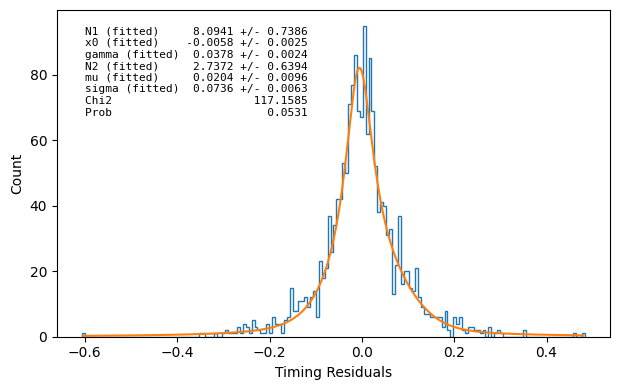

In [49]:
Nbins = int(len(time_res) / 10)
xmin, xmax = min(time_res_binned), max(time_res_binned)
binwidth = (xmax - xmin) / Nbins
x_val = np.linspace(xmin, xmax, 10000)

fig, ax = plt.subplots(figsize=(6.3, 4))
ax.hist(time_res, bins=Nbins, histtype='step', label='Histogram' )
ax.plot(x_val, fit_combo(x_val, *minuit_combo.values))
ax.set(xlabel="Timing Residuals", ylabel="Count")

# Define figure text
d = {'N1 (fitted)': [minuit_combo.values[0], minuit_combo.errors[0]],
     'x0 (fitted)': [minuit_combo.values[1], minuit_combo.errors[1]],
     'gamma (fitted)': [minuit_combo.values[2], minuit_combo.errors[2]],
     'N2 (fitted)': [minuit_combo.values[3], minuit_combo.errors[3]],
     'mu (fitted)': [minuit_combo.values[4], minuit_combo.errors[4]],
     'sigma (fitted)': [minuit_combo.values[5], minuit_combo.errors[5]],
     'Chi2': Chi2_combo,
     'Prob': Prob_combo
    }

# Plot figure text
text = nice_string_output(d, extra_spacing=1, decimals=4)
add_text_to_ax(0.05, 0.95, text, ax, fontsize=8)

fig.tight_layout()
fig.savefig('time_res_combo.png', dpi = 150)